# Vision Neural Network

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow import profiler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
profiler.experimental.stop

## Import CIFAR-10 Data

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

In [3]:
# Normalize data
X_train = X_train / 255.0
X_test = X_test / 255.0

In [4]:
# Convert labels to arrays
y_train = y_train[:, 0]
y_test = y_test[:, 0]

In [5]:
# Convert labels to one hot
z_train = np.zeros((y_train.shape[0], 10))
z_train[np.arange(z_train.shape[0]), y_train] = 1

z_test = np.zeros((y_test.shape[0], 10))
z_test[np.arange(z_test.shape[0]), y_test] = 1

y_train, y_test = z_train, z_test
del z_train, z_test

In [6]:
def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

In [7]:
X_train = grayscale(X_train)
X_test = grayscale(X_test)

In [8]:
# Labels according to the index
Labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# 50000 images of 32x32 size with 3 channels
print("X_train:", X_train.shape)
print("y_train", y_train.shape)

# 10000 images of 32x32 size with 3 channels
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train: (50000, 32, 32, 1)
y_train (50000, 10)
X_test (10000, 32, 32, 1)
y_test (10000, 10)


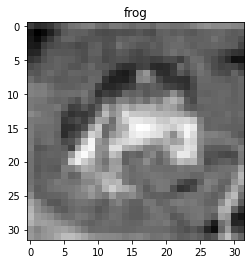

In [9]:
index = 0

plt.title(Labels[y_train[index].argmax()])
plt.imshow(X_train[index], cmap=plt.cm.gray)
plt.show()

## Build the Retina + VVS Model 

In [10]:
def define_model(ret_channels, vvs_layers):
    """
    This function returns a keras model given the number of output channels for the Retina-Net
    and the number of convolutional layers of the VVS-Net
    """
    
    # Retina Network
    inputs = keras.layers.Input((32, 32, 1))
    ret_conv1 = keras.layers.Conv2D(32, (9, 9), padding="same", activation='relu')(inputs)
    ret_bn1 = keras.layers.BatchNormalization()(ret_conv1)
    ret_conv2 = keras.layers.Conv2D(ret_channels, (9, 9), padding="same", activation="relu")(ret_bn1)
    ret_bn2 = keras.layers.BatchNormalization()(ret_conv2)
    
    # VVS-Network
    vvs_bn = ret_bn2
    for _ in range(vvs_layers):
        vvs_conv = keras.layers.Conv2D(32, (9, 9), padding="same", activation="relu")(vvs_bn)
        vvs_bn = keras.layers.BatchNormalization()(vvs_conv)
    vvs_flatten = keras.layers.Flatten()(vvs_bn)
    vvs_fc1 = keras.layers.Dense(1024, activation="relu")(vvs_flatten)
    outputs = keras.layers.Dense(10, activation="softmax")(vvs_fc1)
    
    return keras.Model(inputs, outputs)

In [11]:
# Model hyperparameters
batch_size = 128
ret_channels = 32
vvs_layers = 4

In [12]:
# Create the model
model = define_model(ret_channels=ret_channels, vvs_layers=vvs_layers)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        2624      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        82976     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        82976     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)       

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=["accuracy", keras.metrics.AUC()])

In [14]:
name = f"Retina:{ret_channels}|VVS:{vvs_layers}|BatchSize:{batch_size}"

# Model Callbacks

In [15]:
# Tensorboard
TB = keras.callbacks.TensorBoard("tf_logs/" + name, write_images=True)

# Early Stopping
ES = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=2, mode="min")

# Model Checkpoint
MC = keras.callbacks.ModelCheckpoint("models/" + name + ".h5", save_best_only=True, monitor="val_loss",
                                     mode="min")

# Reduce LR on Plateau
LR = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6)

# Train the model

In [16]:
model.fit(X_train, y_train, batch_size=batch_size, validation_split=0.2,
          epochs=100, callbacks=[TB, ES, MC, LR], shuffle=True)

Epoch 1/100
  1/313 [..............................] - ETA: 0s - loss: 3.1782 - accuracy: 0.0625 - auc: 0.5056WARNING:tensorflow:From /home/gilbertocunha/.local/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
313/313 [==============================] - 576s 2s/step - loss: 2.2627 - accuracy: 0.3200 - auc: 0.7717 - val_loss: 2.5325 - val_accuracy: 0.2049 - val_auc: 0.6762
Epoch 2/100
313/313 [==============================] - 566s 2s/step - loss: 1.5442 - accuracy: 0.4411 - auc: 0.8604 - val_loss: 1.7818 - val_accuracy: 0.3844 - val_auc: 0.8240
Epoch 3/100
313/313 [==============================] - 560s 2s/step - loss: 1.3021 - accuracy: 0.5399 - auc: 0.9024 - val_loss: 1.4518 - val_accuracy: 0.5040 - val_auc: 0.8846
Epoch 4/100
313/313 [==============================] - 587s 2s/step - loss: 1.11

KeyboardInterrupt: 